# Purpose of this notebook



This notebook explores the iSamples API, which provides access to a collection of sample records from various sources (OPENCONTEXT, SESAR, GEOME, SMITHSONIAN). It demonstrates how to:

* Connect to the API and make queries using the IsbClient2 class
* Filter records by source, date range, and other parameters
* Perform faceted searches and analyze results
* Visualize data using matplotlib and interactive widgets
* Work with geospatial data in GeoParquet format
* The notebook contains a mix of explanatory markdown and code cells exploring different aspects of the API, particularly the Solr-based /thing/select endpoint.

Key components:

* Setup code for importing required libraries and initializing the API client
* Exploration of API endpoints and parameters
* Demonstration of querying and filtering with various parameters
* Faceted search examples to aggregate data
* Data visualization including temporal plots and geospatial mapping
* Interactive UI components using Jupyter widgets

In [1]:
import subprocess
import json
from urllib.request import urlopen

def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def install_dependencies_from_pyproject():
    # URL to raw pyproject.toml file in your GitHub repository
    pyproject_url = "https://raw.githubusercontent.com/rdhyee/isamples-python/exploratory/pyproject.toml"
    
    with urlopen(pyproject_url) as response:
        pyproject_content = response.read().decode()
    
    # Parse the TOML content
    import toml
    pyproject_data = toml.loads(pyproject_content)
    
    # Extract dependencies
    dependencies = pyproject_data.get('tool', {}).get('poetry', {}).get('dependencies', {})
    
    # Install each dependency
    for package, version in dependencies.items():
        if isinstance(version, str):
            subprocess.run(['pip', 'install', f"{package}{version}"])
        elif isinstance(version, dict):
            # Handle more complex version specifications
            version_str = version.get('version', '')
            subprocess.run(['pip', 'install', f"{package}{version_str}"])

if in_colab():
    # Install toml parser first
    subprocess.run(['pip', 'install', 'toml'])
    install_dependencies_from_pyproject()
    # pip install git+https://github.com/rdhyee/isamples-python.git@exploratory#egg=isamples_client
    subprocess.run(['pip', 'install', 'git+https://github.com/rdhyee/isamples-python.git@exploratory#egg=isamples_client'])

    from google.colab import output
    output.enable_custom_widget_manager()


In [2]:
# create pybash macro
# https://stackoverflow.com/a/67029719/7782
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

ipython = get_ipython()

@register_cell_magic
def pybash(line, cell):
    ipython.run_cell_magic('bash', '', cell.format(**globals()))

In [3]:
import sys
from pathlib import Path as P


"""
This notebook is part of the iSamples repository. To ensure we can import the iSamples library
directly from the source code in this repository, we manually manipulate sys.path. This allows us
to include the iSamples library without needing to install it as a separate package. By adding the
parent directory of the iSamples library to sys.path, we can import the library modules directly.
"""

# path of the current notebook
lib_path = P.resolve(P.cwd() / '../../src')
# check to see whether a directory which ends with "isamples-python/src" exists in the path
if lib_path.exists() and not any([path.endswith("isamples-python/src") for path in sys.path]):
    sys.path.insert(0, str(lib_path))

import isamples_client



In [4]:
import json
import logging
import httpx
import xarray
import pysolr
import multidict
from datetime import datetime


from urllib.parse import quote

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter
from isamples_client import IsbClient, MAJOR_FIELDS, FL_DEFAULT, FACET_FIELDS_DEFAULT, FACET_RANGE_FIELDS_DEFAULT, ISAMPLES_SOURCES

# creating a subclass of IsbClient because we're still working out the best ways to interact with the API
from isamples_client import IsbClient2

from isamples_client import format_date_for_solr, create_date_range_query, filter_null_values
from isamples_client import monkey_patch_select, SWITCH_TO_POST


from itertools import islice

logging.getLogger().setLevel(logging.INFO)

# monkeypatch pysolr?
monkey_patch_select(active=True)
SWITCH_TO_POST = 10000


# The overall iSamples API

* https://central.isample.xyz/isamples_central/docs is the swagger UI
* https://central.isample.xyz/isamples_central/openapi.json is the OpenAPI spec file for the iSamples API.

There are Python libraries for enabling devs to interact with an API specified by an OpenAPI spec, but my current thought is that they don't make life any easier than to work with pieces of the API by hand.


In [5]:
# https://central.isample.xyz/isamples_central/openapi.json is an OPENAPI 3.x spec

OPENAPI_URL = 'https://central.isample.xyz/isamples_central/openapi.json'
r = httpx.get(OPENAPI_URL)
r.json()['paths'].keys()

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/openapi.json "HTTP/1.1 200 OK"


dict_keys(['/metrics', '/metrics/', '/vocabulary/material_sample_object_type', '/vocabulary/material_sample_type', '/vocabulary/material_type', '/vocabulary/sampled_feature_type', '/thing', '/thing/', '/thing/types', '/thing/select', '/thing/select/', '/thing/reliquery', '/thing/stream', '/thing/select/info', '/h3_counts/', '/things', '/thing/{identifier}', '/resolve/{identifier}', '/stac_item/{identifier}', '/stac_collection/{filename}', '/things_geojson_heatmap', '/things_leaflet_heatmap', '/related', '/related/'])

# /thing/select: Solr-based select interface

The most important part of the iSamples API

In [6]:
# focus on /thing/select endpoint
r = httpx.get(OPENAPI_URL)
r.json()['paths']['/thing/select']['get']

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/openapi.json "HTTP/1.1 200 OK"


{'tags': ['solr'],
 'summary': 'Thing query GET, query is read off query parameters',
 'operationId': 'get_solr_select_thing_select_get',
 'responses': {'200': {'description': 'Successful Response',
   'content': {'application/json': {'schema': {'title': 'Response Get Solr Select Thing Select Get'}}}}}}

# documentation about Solr query language

[The Standard Query Parser | Apache Solr Reference Guide 8.11](https://solr.apache.org/guide/8_11/the-standard-query-parser.html#standard-query-parser-parameters):

> Solr’s default Query Parser is also known as the “lucene” parser.   
> [....]   
> q: Defines a query using standard query syntax. This parameter is mandatory

Note [Differences between Lucene’s Classic Query Parser and Solr’s Standard Query Parser](https://solr.apache.org/guide/8_11/the-standard-query-parser.html#differences-between-lucenes-classic-query-parser-and-solrs-standard-query-parser)

there are "existence searches" [The Standard Query Parser | Apache Solr Reference Guide 8.11](https://solr.apache.org/guide/8_11/the-standard-query-parser.html#existence-searches):

> An existence search for a field matches all documents where a value exists for that field. To query for a field existing, simply use a wildcard instead of a term in the search.
>
> field:*
>
> A field will be considered to "exist" if it has any value, even values which are often considered "not existent". (e.g., NaN, "", etc.)

Good tutorial on the query syntax of Solr (apart from the official documentation): [Solr Query Syntax and Examples](https://yonik.com/solr/query-syntax/)


## why fq, rather than q, is the key parameter to vary

We set `q=*:*` and vary `fq`.  By doing so, you can cache results by varying `fq`. Also changing `fq` doesn't change the score.  (A better explanation should be put here because the distinction between `q` and `fq` is something that is not obvious to people new to Solr. ([Difference between q and fq in Solr - Stack Overflow](https://stackoverflow.com/questions/20988516/difference-between-q-and-fq-in-solr))

Translate the UI from https://central.isample.xyz/isamples_central/ui into widgetized forms to formulate query

* display number of hits
* display facets

map
dataframe


# IsbClient2

TO DO: fold IsbClient2 into IsbClient

In [ ]:
# Initialize the iSamples client with default configuration
cli = IsbClient2()

# Create a filter query specifically for OpenContext records up to current year
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',), collection_date_end=str(datetime.now().year))

# Prepare search parameters with faceting enabled
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)

In [8]:
params

{'q': '*:*',
 'fl': ('searchText',
  'authorizedBy',
  'producedBy_resultTimeRange',
  'hasContextCategory',
  'curation_accessContraints',
  'curation_description_text',
  'curation_label',
  'curation_location',
  'curation_responsibility',
  'description_text',
  'id',
  'informalClassification',
  'keywords',
  'label',
  'hasMaterialCategory',
  'producedBy_description_text',
  'producedBy_hasFeatureOfInterest',
  'producedBy_label',
  'producedBy_responsibility',
  'producedBy_resultTime',
  'producedBy_samplingSite_description_text',
  'producedBy_samplingSite_label',
  'producedBy_samplingSite_location_elevationInMeters',
  'producedBy_samplingSite_location_latitude',
  'producedBy_samplingSite_location_longitude',
  'producedBy_samplingSite_placeName',
  'registrant',
  'samplingPurpose',
  'source',
  'sourceUpdatedTime',
  'producedBy_samplingSite_location_rpt',
  'hasSpecimenCategory'),
 'start': 0,
 'rows': 100,
 'fq': ['producedBy_resultTimeRange:[1800 TO 2025]',
  'sourc

In [ ]:
# Retrieve facet information to understand data distribution
facets = cli.facets(params=params)
facets

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/thing/select?q=%2A%3A%2A&fl=searchText&fl=authorizedBy&fl=producedBy_resultTimeRange&fl=hasContextCategory&fl=curation_accessContraints&fl=curation_description_text&fl=curation_label&fl=curation_location&fl=curation_responsibility&fl=description_text&fl=id&fl=informalClassification&fl=keywords&fl=label&fl=hasMaterialCategory&fl=producedBy_description_text&fl=producedBy_hasFeatureOfInterest&fl=producedBy_label&fl=producedBy_responsibility&fl=producedBy_resultTime&fl=producedBy_samplingSite_description_text&fl=producedBy_samplingSite_label&fl=producedBy_samplingSite_location_elevationInMeters&fl=producedBy_samplingSite_location_latitude&fl=producedBy_samplingSite_location_longitude&fl=producedBy_samplingSite_placeName&fl=registrant&fl=samplingPurpose&fl=source&fl=sourceUpdatedTime&fl=producedBy_samplingSite_location_rpt&fl=hasSpecimenCategory&start=0&rows=0&fq=producedBy_resultTimeRange%3A%5B1800+TO+2025%5D&fq=sour

{'authorizedBy': {},
 'hasContextCategory': {'https://w3id.org/isample/vocabulary/sampledfeature/1.0/pasthumanoccupationsite': 1064831},
 'hasMaterialCategory': {'https://w3id.org/isample/vocabulary/material/1.0/biogenicnonorganicmaterial': 745539,
  'https://w3id.org/isample/vocabulary/material/1.0/rock': 295730,
  'https://w3id.org/isample/vocabulary/material/1.0/anthropogenicmetal': 270040,
  'https://w3id.org/isample/vocabulary/material/1.0/material': 163373,
  'https://w3id.org/isample/opencontext/material/0.1/ceramicclay': 100573,
  'https://w3id.org/isample/vocabulary/material/1.0/organicmaterial': 56011,
  'https://w3id.org/isample/vocabulary/material/1.0/anyanthropogenicmaterial': 44249,
  'https://w3id.org/isample/vocabulary/material/1.0/earthmaterial': 27574,
  'https://w3id.org/isample/opencontext/material/0.1/organicanimalproduct': 266,
  'https://w3id.org/isample/opencontext/material/0.1/plantmaterial': 1},
 'registrant': {'': 834405},
 'source': {'OPENCONTEXT': 1064831},

In [ ]:
# Execute search query and get response with metadata
response = cli.search(params=params, thingselect=True)
# print number of hits
print (response['response']['numFound'])

# Convert results to DataFrame for easier manipulation
df = DataFrame(response)
df.head()

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/thing/select?q=%2A%3A%2A&fl=searchText&fl=authorizedBy&fl=producedBy_resultTimeRange&fl=hasContextCategory&fl=curation_accessContraints&fl=curation_description_text&fl=curation_label&fl=curation_location&fl=curation_responsibility&fl=description_text&fl=id&fl=informalClassification&fl=keywords&fl=label&fl=hasMaterialCategory&fl=producedBy_description_text&fl=producedBy_hasFeatureOfInterest&fl=producedBy_label&fl=producedBy_responsibility&fl=producedBy_resultTime&fl=producedBy_samplingSite_description_text&fl=producedBy_samplingSite_label&fl=producedBy_samplingSite_location_elevationInMeters&fl=producedBy_samplingSite_location_latitude&fl=producedBy_samplingSite_location_longitude&fl=producedBy_samplingSite_placeName&fl=registrant&fl=samplingPurpose&fl=source&fl=sourceUpdatedTime&fl=producedBy_samplingSite_location_rpt&fl=hasSpecimenCategory&start=0&rows=0&fq=producedBy_resultTimeRange%3A%5B1800+TO+2025%5D&fq=sour

1064831


,responseHeader,response,nextCursorMark,facet_counts
zkConnected,True,NaN,*,NaN
status,0,NaN,*,NaN
QTime,272,NaN,*,NaN
params,"{'facet.range': 'producedBy_resultTimeRange', ...",NaN,*,NaN
numFound,NaN,1064831,*,NaN


In [11]:
df

,responseHeader,response,nextCursorMark,facet_counts
zkConnected,True,NaN,*,NaN
status,0,NaN,*,NaN
QTime,272,NaN,*,NaN
params,"{'facet.range': 'producedBy_resultTimeRange', ...",NaN,*,NaN
numFound,NaN,1064831,*,NaN
start,NaN,0,*,NaN
numFoundExact,NaN,True,*,NaN
docs,NaN,[],*,NaN
facet_queries,NaN,NaN,*,{}
facet_fields,NaN,NaN,*,"{'authorizedBy': [], 'hasContextCategory': ['h..."


In [12]:
df.loc['facet_fields', 'facet_counts']

{'authorizedBy': [],
 'hasContextCategory': ['https://w3id.org/isample/vocabulary/sampledfeature/1.0/pasthumanoccupationsite',
  1064831],
 'hasMaterialCategory': ['https://w3id.org/isample/vocabulary/material/1.0/biogenicnonorganicmaterial',
  745539,
  'https://w3id.org/isample/vocabulary/material/1.0/rock',
  295730,
  'https://w3id.org/isample/vocabulary/material/1.0/anthropogenicmetal',
  270040,
  'https://w3id.org/isample/vocabulary/material/1.0/material',
  163373,
  'https://w3id.org/isample/opencontext/material/0.1/ceramicclay',
  100573,
  'https://w3id.org/isample/vocabulary/material/1.0/organicmaterial',
  56011,
  'https://w3id.org/isample/vocabulary/material/1.0/anyanthropogenicmaterial',
  44249,
  'https://w3id.org/isample/vocabulary/material/1.0/earthmaterial',
  27574,
  'https://w3id.org/isample/opencontext/material/0.1/organicanimalproduct',
  266,
  'https://w3id.org/isample/opencontext/material/0.1/plantmaterial',
  1],
 'registrant': ['', 834405],
 'source': ['O

In [ ]:
# what's the number of records that are geocoded in OpenContext

# get OpenContext sourced records
# fq=-lat:[* TO *] AND -long:[* TO *]&rows=0
# fq = cli._fq_from_kwargs(source=('OPENCONTEXT',), collection_date_end=str(datetime.now().year))
# Extract only records without latitude/longitude coordinates

geodict = multidict.MultiDict({
  '-producedBy_samplingSite_location_latitude':'[* TO *]', 
  '-producedBy_samplingSite_location_longitude': '[* TO *]'
})

fq = cli._fq_from_kwargs(source=('OPENCONTEXT',), collection_date_end=str(datetime.now().year), 
        _multi=geodict )

params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)

# use the /thing/select endpoint directly
response = cli.search(params=params, thingselect=True)
# print number of hits
print (response['response']['numFound'])
results = islice(response, 300)

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/thing/select?q=%2A%3A%2A&fl=searchText&fl=authorizedBy&fl=producedBy_resultTimeRange&fl=hasContextCategory&fl=curation_accessContraints&fl=curation_description_text&fl=curation_label&fl=curation_location&fl=curation_responsibility&fl=description_text&fl=id&fl=informalClassification&fl=keywords&fl=label&fl=hasMaterialCategory&fl=producedBy_description_text&fl=producedBy_hasFeatureOfInterest&fl=producedBy_label&fl=producedBy_responsibility&fl=producedBy_resultTime&fl=producedBy_samplingSite_description_text&fl=producedBy_samplingSite_label&fl=producedBy_samplingSite_location_elevationInMeters&fl=producedBy_samplingSite_location_latitude&fl=producedBy_samplingSite_location_longitude&fl=producedBy_samplingSite_placeName&fl=registrant&fl=samplingPurpose&fl=source&fl=sourceUpdatedTime&fl=producedBy_samplingSite_location_rpt&fl=hasSpecimenCategory&start=0&rows=100&fq=producedBy_resultTimeRange%3A%5B1800+TO+2025%5D&fq=so

78


In [14]:
cli._fq_from_kwargs(source=('OPENCONTEXT',), collection_date_end=str(datetime.now().year), 
        producedBy_samplingSite_location_latitude='[* TO *]', producedBy_samplingSite_location_longitude='[* TO *]' )

['producedBy_resultTimeRange:[1800 TO 2025]',
 'source:"OPENCONTEXT"',
 '-relation_target:*',
 'producedBy_samplingSite_location_latitude:[* TO *]',
 'producedBy_samplingSite_location_longitude:[* TO *]']

In [15]:
logging.getLogger().setLevel(logging.CRITICAL)

# monkeypatch pysolr?
monkey_patch_select(active=True)
SWITCH_TO_POST = 100000

cli = IsbClient2()
# build fq: OpenContext source and search for bone
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',), searchText="bone")
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)

# use pysolr to get the results
response = cli.search(params=params)
# print number of hits
print (len(response))
results = islice(response, 1000)

df = DataFrame(results)
df.head(2)

523885


,id,sourceUpdatedTime,label,searchText,description_text,hasContextCategory,hasMaterialCategory,hasSpecimenCategory,keywords,registrant,...,producedBy_resultTime,producedBy_resultTimeRange,producedBy_samplingSite_description_text,producedBy_samplingSite_label,producedBy_samplingSite_placeName,producedBy_samplingSite_location_rpt,producedBy_samplingSite_location_latitude,producedBy_samplingSite_location_longitude,source,curation_accessContraints
0,ark:/28722/k2000027w,2023-10-04T06:00:39Z,Animal Bone Bone Ref# 3008,"[Animal Bone Bone Ref# 3008, 'early bce/ce': -...",'early bce/ce': -6700.0 | 'late bce/ce': -6000...,[https://w3id.org/isample/vocabulary/sampledfe...,[https://w3id.org/isample/vocabulary/material/...,[https://w3id.org/isample/opencontext/material...,"[Agriculture, Animal remains (Archaeology), Ar...",[],...,2013-03-04T00:00:00Z,2013-03-04T00:00:00Z,https://opencontext.org/subjects/2767a2d2-a050...,Pınarbaşı,"[Asia, Turkey, Pınarbaşı, Site B, Context BCF]",POINT (33.018551 37.49432),37.49432,33.01855,OPENCONTEXT,NaN
1,ark:/28722/k2000028c,2023-10-04T05:58:40Z,Animal Bone Bone Ref# 2237,"[Animal Bone Bone Ref# 2237, 'early bce/ce': -...",'early bce/ce': -6700.0 | 'late bce/ce': -6000...,[https://w3id.org/isample/vocabulary/sampledfe...,[https://w3id.org/isample/vocabulary/material/...,[https://w3id.org/isample/opencontext/material...,"[Agriculture, Animal remains (Archaeology), Ar...",[],...,2013-03-04T00:00:00Z,2013-03-04T00:00:00Z,https://opencontext.org/subjects/2767a2d2-a050...,Pınarbaşı,"[Asia, Turkey, Pınarbaşı, Site B, Context BBJ]",POINT (33.018551 37.49432),37.49432,33.01855,OPENCONTEXT,NaN


In [16]:
cli.record_count(params=params)

523885

In [17]:
# goal: figure out how to get facet counts and pivoting

cli = IsbClient2()
# build fq: OpenContext source and search for bone
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',), searchText="bone")
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)

In [18]:
resp0 = cli.search(params=params, thingselect=True)
resp0.get("facet_counts",{}).get("facet_fields",{}).keys() #.get(field, [])

dict_keys(['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'])

In [19]:
# let's look at the data coming back and see how to make sense of them.
# expect the columns in the DataFrame to be a proper subset of FL_DEFAULT


def set_diff(a, b):
    return set(a) - set(b), set(b) - set(a)
    


assert set(df.columns) - set(FL_DEFAULT) == set()


len(df)

1000

In [20]:
# can I get type information from the API?
# it doesn't seem like /thing/select will return type information

# save a copy of df to df0
df0 = df.copy()

# df.infer_objects().dtypes
df = df.convert_dtypes()

# some of the columns are datetimes
for k in ['sourceUpdatedTime', 'producedBy_resultTime', 'producedBy_resultTimeRange']:
    df[k] = pd.to_datetime(df[k], errors='coerce').dt.tz_localize(None)

# spit out to Excel to look at the data in spreadsheet form
df.to_excel('bone.xlsx')


In [21]:
df['sourceUpdatedTime'].describe()

count                             1000
mean     2023-10-08 00:59:48.161000192
min                2023-10-03 21:16:17
25%                2023-10-04 09:02:13
50%         2023-10-04 13:27:03.500000
75%      2023-10-06 19:19:53.249999872
max                2024-11-18 02:37:19
Name: sourceUpdatedTime, dtype: object

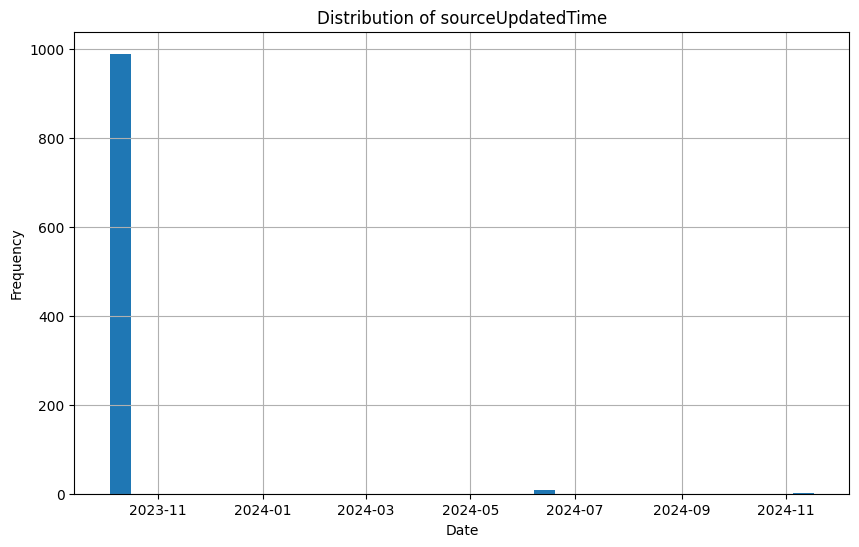

In [22]:
import matplotlib.pyplot as plt

# Convert the datetime64 column to just date
df['sourceUpdatedTime'] = df['sourceUpdatedTime'].dt.date

# Plot a histogram
plt.figure(figsize=(10,6))
df['sourceUpdatedTime'].hist(rwidth=0.9, bins=30)
plt.title('Distribution of sourceUpdatedTime')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

In [23]:
import ipydatagrid as ipg
ipg.__version__

'1.4.0'

In [24]:
len(df)

1000

In [25]:
# load the df into ipydatagrid
from ipydatagrid import DataGrid

dg = DataGrid(df, editable=True)
dg

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [26]:
df.shape

(1000, 23)

In [27]:
# what type of events are supported by ipydatagrid
# selection events, what rows are shown? what columns?
dg.selection_mode, dg.selected_cells

('cell', [])

In [28]:
def analyze_selection_from_dg(selection, total_rows, total_columns):
    # Initialize counters
    row_counts = {}
    
    # Process each selected cell
    for cell in selection:
        row_index = cell['r']
        # Increment the row counter for each occurrence
        if row_index in row_counts:
            row_counts[row_index] += 1
        else:
            row_counts[row_index] = 1
    
    # Analyze the counts to determine full row selections
    full_rows_selected = [row for row, count in row_counts.items() if count == total_columns]
    
    # Report findings
    if full_rows_selected:
        print(f"Full rows selected: Rows {full_rows_selected}")
    else:
        print("No full rows selected.")

# Assuming you have a DataFrame 'df' and a DataGrid 'dg' with selections as described
total_rows, total_columns = df.shape  # As per your DataFrame's shape

# Example selection (assuming this comes from dg.selected_cells)
selected_cells =  dg.selected_cells
# Analyze the selection
analyze_selection_from_dg(selected_cells, total_rows, total_columns)

No full rows selected.


In [ ]:
# use Jupyter widgets to allow for change in searchText and display the number of results in a output widget

import ipywidgets as widgets
from IPython.display import display

logging.getLogger().setLevel(logging.CRITICAL)

# monkeypatch pysolr?
monkey_patch_select(active=True)
SWITCH_TO_POST = 100000

cli = IsbClient2()

# build fq: OpenContext source and search for bone
fq = cli._fq_from_kwargs(searchText="bone")
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=10, **FACET_RANGE_FIELDS_DEFAULT)
query = cli.search(params=params)
num_hits = len(query)

# Create interactive search functionality with widgets
search_text = widgets.Text(
    value='',
    placeholder='Type something',
    description='Search:',
)

# Date range slider for filtering by production time
producedby_range_slider = widgets.IntRangeSlider(
    value=[1800, 2024],
    min=1800,
    max=2024,
    step=1,
    description='ProducedBy ResultTime:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

# Create an output widget
output = widgets.Output()

# Callback function that updates results when input changes
def on_text_change(change):
    output.clear_output()  # Clear the previous results

    # Get the new search text and range values
    new_search_text = search_text.value
    new_range = producedby_range_slider.value

    fq = cli._fq_from_kwargs(searchText=new_search_text, collection_date_start=new_range[0], collection_date_end=new_range[1])
    params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=10, **FACET_RANGE_FIELDS_DEFAULT)
    query = cli.search(params=params)
    num_hits = len(query)

    with output:
        print(f"Number of hits: {num_hits}")  # Display the new search text

# Attach the event handler to the text input and range slider
search_text.observe(on_text_change, names='value')
producedby_range_slider.observe(on_text_change, names='value')

# Display the widgets
# align the widgets vertically
display(widgets.VBox([producedby_range_slider, search_text, output]))


In [30]:
# write out the call to iSamples using httpx to compare get vs post

import httpx
ISB_SERVER = "https://central.isample.xyz/isamples_central/"

r = httpx.request('GET', f'{ISB_SERVER}/thing/select', params=params)
r.json()['response']['numFound']

524372

In [31]:
# make a post request version

from urllib.parse import urlencode

headers = {
    "Content-type": "application/x-www-form-urlencoded; charset=utf-8"
}

params_encoded = urlencode(params)
r = httpx.post(f'{ISB_SERVER}/thing/select', data=params_encoded, headers=headers)
r

<Response [400 Bad Request]>

In [32]:
r.json()

{'detail': 'application/json is only supported Content-Type. application/x-www-form-urlencoded; charset=utf-8 is not supported.'}

In [33]:
assert set(query.raw_response.keys()) == set(['responseHeader', 'response', 'nextCursorMark', 'facet_counts'])

In [34]:
# dict_keys(['facet_queries', 'facet_fields', 'facet_ranges', 'facet_intervals', 'facet_heatmaps'])
query.raw_response['facet_counts'].keys()

query.raw_response['facet_counts']['facet_fields'].keys()

dict_keys(['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'])

In [35]:
query.raw_response['facet_counts']['facet_fields']['source']

['OPENCONTEXT', 523885, 'GEOME', 300, 'SESAR', 132, 'SMITHSONIAN', 55]

In [36]:
from ipytree import Tree, Node
from ipyleaflet import Map, Marker
from ipywidgets import HBox, link, Layout

m = Map(center=[47.51, 4.04], zoom=4, layout=Layout(height='400px'))
tree = Tree()
tree.layout.width = '40%'
box = HBox([tree, m])

markers_node = Node('Markers')
tree.add_node(markers_node)

layers_node = Node('Layers', icon='map')
tree.add_node(layers_node)

cities = [
    {'name': 'London', 'location': [51.5074, 0.1278]},
    {'name': 'Paris', 'location': [48.8566, 2.3522]},
    {'name': 'Barcelona', 'location': [41.31, 2.109]}
]

for city in cities:
    marker = Marker(location=city.get('location'))
    node = Node(city.get('name'), icon='map-marker')

    link((marker, 'visible'), (node, 'selected'))

    m.add_layer(marker)
    markers_node.add_node(node)

box

In [37]:
# query.raw_response.keys() --> dict_keys(['responseHeader', 'response', 'nextCursorMark', 'facet_counts'])
query.raw_response['facet_counts']['facet_ranges'].keys()

dict_keys(['producedBy_resultTimeRange'])

In [38]:
# keys: dict_keys(['facet_queries', 'facet_fields', 'facet_ranges', 'facet_intervals', 'facet_heatmaps'])
query.raw_response['facet_counts']['facet_ranges'].keys()

dict_keys(['producedBy_resultTimeRange'])

In [39]:
# 'responseHeader', 'index', 'schema', 'info'
r = cli._request("thing/select/info")
r.keys()

dict_keys(['responseHeader', 'index', 'schema', 'info'])

In [40]:
r['schema']['fields'].keys()

dict_keys(['_nest_parent_', '_nest_path_', '_root_', '_text_', '_version_', 'authorizedBy', 'compliesWith', 'curation_accessContraints', 'curation_description', 'curation_description_text', 'curation_label', 'curation_location', 'curation_responsibility', 'description', 'description_text', 'hasContextCategory', 'hasContextCategoryConfidence', 'hasMaterialCategory', 'hasMaterialCategoryConfidence', 'hasSpecimenCategory', 'hasSpecimenCategoryConfidence', 'id', 'indexUpdatedTime', 'informalClassification', 'isb_core_id', 'keywords', 'label', 'producedBy_description', 'producedBy_description_text', 'producedBy_hasFeatureOfInterest', 'producedBy_isb_core_id', 'producedBy_label', 'producedBy_responsibility', 'producedBy_resultTime', 'producedBy_resultTimeRange', 'producedBy_samplingSite_description', 'producedBy_samplingSite_description_text', 'producedBy_samplingSite_label', 'producedBy_samplingSite_location_bb', 'producedBy_samplingSite_location_bb__maxX', 'producedBy_samplingSite_location

In [41]:
# timeout internal server error -- skip trying to query thing/types right now. https://github.com/isamplesorg/isamples_inabox/issues/351
if False:
    r = cli._request("thing/types")

In [42]:
# types and classnames for all the fields on the system
Counter([(x['type'], r['schema']['types'][x['type']]['className']) for x in r['schema']['fields'].values()])

Counter({('string', 'org.apache.solr.schema.StrField'): 48,
         ('pfloat', 'org.apache.solr.schema.FloatPointField'): 7,
         ('text_en', 'org.apache.solr.schema.TextField'): 5,
         ('pdouble', 'org.apache.solr.schema.DoublePointField'): 4,
         ('pdate', 'org.apache.solr.schema.DatePointField'): 3,
         ('_nest_path_', 'org.apache.solr.schema.NestPathField'): 1,
         ('text_general', 'org.apache.solr.schema.TextField'): 1,
         ('plong', 'org.apache.solr.schema.LongPointField'): 1,
         ('date_range', 'org.apache.solr.schema.DateRangeField'): 1,
         ('bbox', 'org.apache.solr.schema.BBoxField'): 1,
         ('boolean', 'org.apache.solr.schema.BoolField'): 1,
         ('location', 'org.apache.solr.schema.LatLonPointSpatialField'): 1,
         ('location_rpt',
          'org.apache.solr.schema.SpatialRecursivePrefixTreeFieldType'): 1})

In [43]:
# e.g, I for Indexed, T for Tokenized, S for Stored, etc.
r['info']['key']

# ['fields', 'dynamicFields', 'uniqueKeyField', 'similarity', 'types']
r['schema'].keys()

# get the fields -- 78 of them
print ("number of fields", len(r['schema']['fields'].keys()))

field_names = cli.field_names()
print("number of field names (another way to access)", len(field_names))

print ("types for the major fields")
[(k,v['type'], r['schema']['types'][v['type']]['className'] ) for (k,v) in r['schema']['fields'].items() if k in MAJOR_FIELDS.values()]

number of fields 75
number of field names (another way to access) 75
types for the major fields


[('hasContextCategory', 'string', 'org.apache.solr.schema.StrField'),
 ('hasMaterialCategory', 'string', 'org.apache.solr.schema.StrField'),
 ('hasSpecimenCategory', 'string', 'org.apache.solr.schema.StrField'),
 ('id', 'string', 'org.apache.solr.schema.StrField'),
 ('keywords', 'string', 'org.apache.solr.schema.StrField'),
 ('label', 'string', 'org.apache.solr.schema.StrField'),
 ('producedBy_resultTime', 'pdate', 'org.apache.solr.schema.DatePointField'),
 ('producedBy_resultTimeRange',
  'date_range',
  'org.apache.solr.schema.DateRangeField'),
 ('producedBy_samplingSite_location_rpt',
  'location_rpt',
  'org.apache.solr.schema.SpatialRecursivePrefixTreeFieldType'),
 ('producedBy_samplingSite_placeName',
  'string',
  'org.apache.solr.schema.StrField'),
 ('registrant', 'string', 'org.apache.solr.schema.StrField'),
 ('searchText', 'text_en', 'org.apache.solr.schema.TextField'),
 ('source', 'string', 'org.apache.solr.schema.StrField'),
 ('sourceUpdatedTime', 'pdate', 'org.apache.solr.

In [44]:
from urllib.parse import urlparse, parse_qs

url = 'https://central.isample.xyz/isamples_central/thing/select?q=*:*&fl=searchText%20authorizedBy%20producedBy_resultTimeRange%20hasContextCategory%20curation_accessContraints%20curation_description_text%20curation_label%20curation_location%20curation_responsibility%20description_text%20id%20informalClassification%20keywords%20label%20hasMaterialCategory%20producedBy_description_text%20producedBy_hasFeatureOfInterest%20producedBy_label%20producedBy_responsibility%20producedBy_resultTime%20producedBy_samplingSite_description_text%20producedBy_samplingSite_label%20producedBy_samplingSite_location_elevationInMeters%20producedBy_samplingSite_location_latitude%20producedBy_samplingSite_location_longitude%20producedBy_samplingSite_placeName%20registrant%20samplingPurpose%20source%20sourceUpdatedTime%20producedBy_samplingSite_location_rpt%20hasSpecimenCategory&fq=producedBy_resultTimeRange%3A%5B1800%20TO%202023%5D&fq=source%3A(%22OPENCONTEXT%22%20OR%20%22SESAR%22)&fq=-relation_target%3A*&facet.field=authorizedBy&facet.field=hasContextCategory&facet.field=hasMaterialCategory&facet.field=registrant&facet.field=source&facet.field=hasSpecimenCategory&facet.range=producedBy_resultTimeRange&facet.range.gap=%2B1YEARS&facet.range.start=1800-01-01T00:00:00Z&facet.range.end=2023-01-01T00:00:00Z&f.registrant.facet.sort=count&f.source.facet.sort=index&rows=20&facet.limit=-1&facet.sort=index&&start=0&facet=on&wt=json'

parsed_url = urlparse(url)
query_params = parse_qs(parsed_url.query)

# The result is a dictionary where each key is associated with a list of values.
# You can iterate over this dictionary to process your parameters as needed.
for key, values in query_params.items():
    print(f"{key}: {values}")

# If you need each key to have a single value (taking the first value if multiple are present),
# you can do the following:
single_value_params = {key: values[0] for key, values in query_params.items()}
print(single_value_params)


q: ['*:*']
fl: ['searchText authorizedBy producedBy_resultTimeRange hasContextCategory curation_accessContraints curation_description_text curation_label curation_location curation_responsibility description_text id informalClassification keywords label hasMaterialCategory producedBy_description_text producedBy_hasFeatureOfInterest producedBy_label producedBy_responsibility producedBy_resultTime producedBy_samplingSite_description_text producedBy_samplingSite_label producedBy_samplingSite_location_elevationInMeters producedBy_samplingSite_location_latitude producedBy_samplingSite_location_longitude producedBy_samplingSite_placeName registrant samplingPurpose source sourceUpdatedTime producedBy_samplingSite_location_rpt hasSpecimenCategory']
fq: ['producedBy_resultTimeRange:[1800 TO 2023]', 'source:("OPENCONTEXT" OR "SESAR")', '-relation_target:*']
facet.field: ['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory']
facet.range: ['pro

In [45]:
# simplest query -- default

cli._request("thing/select", params={'q': '*:*', 'start':0, 'rows': 10, 
        'fq': ['producedBy_resultTimeRange:[1800 TO 2023]', 'source:(OPENCONTEXT or SESAR)', '-relation_target:*'],
        'facet.field': ['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'],
        'facet': 'on',
        })

{'responseHeader': {'zkConnected': True,
  'status': 0,
  'QTime': 1704,
  'params': {'q': '*:*',
   'facet.field': ['authorizedBy',
    'hasContextCategory',
    'hasMaterialCategory',
    'registrant',
    'source',
    'hasSpecimenCategory'],
   'fl': 'id',
   'start': '0',
   'fq': ['producedBy_resultTimeRange:[1800 TO 2023]',
    'source:(OPENCONTEXT or SESAR)',
    '-relation_target:*'],
   'rows': '10',
   'facet': 'on',
   'wt': 'json'}},
 'response': {'numFound': 5590516,
  'start': 0,
  'numFoundExact': True,
  'docs': [{'id': 'IGSN:001000053'},
   {'id': 'IGSN:001000054'},
   {'id': 'IGSN:001000055'},
   {'id': 'IGSN:001000056'},
   {'id': 'IGSN:001000057'},
   {'id': 'IGSN:001000058'},
   {'id': 'IGSN:001000059'},
   {'id': 'IGSN:00100005R'},
   {'id': 'IGSN:00100005S'},
   {'id': 'IGSN:00100005T'}]},
 'facet_counts': {'facet_queries': {},
  'facet_fields': {'authorizedBy': [],
   'hasContextCategory': ['https://w3id.org/isample/vocabulary/sampledfeature/1.0/anysampledfeatu

I *think* I had ChatGPT parse the parameters and give me the following interpretation:

Let's break down these parameters, which are used for querying a Solr search engine. Solr is an open-source search platform that provides a wide range of capabilities for text search and faceted search, among other features.

q: This parameter specifies the query. Here, *:* is a wildcard query, meaning it matches all documents in the Solr index.


[fl](https://solr.apache.org/guide/8_11/common-query-parameters.html#fl-field-list-parameter): This stands for "field list". It specifies the fields to return in the result. In your query, a long list of fields like searchText, authorizedBy, producedBy_resultTimeRange, etc., are included. Only these fields will be returned for each document in the search results.

fq: This is the "filter query". It filters the results returned by the main query (q) without influencing the score. Here, there are three filters applied:

> producedBy_resultTimeRange:[1800 TO 2023] filters documents to those produced between the years 1800 and 2023.
source:(OPENCONTEXT) filters documents where the source field matches "OPENCONTEXT".
-relation_target:* excludes documents where the relation_target field exists.
facet.field: Faceting is used to aggregate data based on a field. This parameter specifies the fields for which you want to see facet counts. Facets on fields like authorizedBy, hasContextCategory, etc., are requested.


facet.range, facet.range.gap, facet.range.start, and facet.range.end: These parameters are used for range faceting. You are faceting on the producedBy_resultTimeRange field, starting from "1800-01-01T00:00:00Z" to "2023-01-01T00:00:00Z", with a gap of "+1YEARS". This means it will provide counts for each year in this range.

f.registrant.facet.sort and f.source.facet.sort: These are sorting instructions for the facets. The registrant facet is sorted by count, and the source facet is sorted by index.

rows: This specifies the number of documents to return. In your query, it's set to 20.

facet.limit: This limits the number of facet values returned for each facet field. -1 means no limit.

facet.sort: It dictates how to sort the facet fields. Here, it's sorted by index.

start: This is the offset in the complete result set for pagination. It tells Solr where to start in the list of results (useful for paging through results).

facet: When set to 'on', it enables faceting.

wt: This stands for "writer type" and specifies the output format. Here, 'json' indicates that the response should be in JSON format.

In [46]:
import httpx


url = "https://central.isample.xyz/isamples_central/thing/select"
params = {
    'q': '*:*',
    'fl': 'searchText authorizedBy producedBy_resultTimeRange hasContextCategory curation_accessContraints curation_description_text curation_label curation_location curation_responsibility description_text id informalClassification keywords label hasMaterialCategory producedBy_description_text producedBy_hasFeatureOfInterest producedBy_label producedBy_responsibility producedBy_resultTime producedBy_samplingSite_description_text producedBy_samplingSite_label producedBy_samplingSite_location_elevationInMeters producedBy_samplingSite_location_latitude producedBy_samplingSite_location_longitude producedBy_samplingSite_placeName registrant samplingPurpose source sourceUpdatedTime producedBy_samplingSite_location_rpt hasSpecimenCategory',
    'fq': ['producedBy_resultTimeRange:[1800 TO 2023]', 'source:(OPENCONTEXT)', '-relation_target:*'],
    'facet.field': ['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'],
    'facet.range': 'producedBy_resultTimeRange',
    'facet.range.gap': '+1YEARS',
    'facet.range.start': '1800-01-01T00:00:00Z',
    'facet.range.end': '2023-01-01T00:00:00Z',
    'f.registrant.facet.sort': 'count',
    'f.source.facet.sort': 'index',
    'rows': '20',
    'facet.limit': '-1',
    'facet.sort': 'index',
    'start': '20',
    'facet': 'on',
    'wt': 'json'
}
headers = {
    'Accept': 'application/json',
    'User-Agent': 'raymondyee.net'
}

# keys in response: 'responseHeader', 'response', 'facet_counts'
response = httpx.get(url, params=params, headers=headers)


In [47]:
# get back parameters that went into the query and some basic metadata
response.json()['responseHeader']

{'zkConnected': True,
 'status': 0,
 'QTime': 288,
 'params': {'facet.range': 'producedBy_resultTimeRange',
  'facet.field': ['authorizedBy',
   'hasContextCategory',
   'hasMaterialCategory',
   'registrant',
   'source',
   'hasSpecimenCategory'],
  'facet.range.gap': '+1YEARS',
  'fl': 'searchText authorizedBy producedBy_resultTimeRange hasContextCategory curation_accessContraints curation_description_text curation_label curation_location curation_responsibility description_text id informalClassification keywords label hasMaterialCategory producedBy_description_text producedBy_hasFeatureOfInterest producedBy_label producedBy_responsibility producedBy_resultTime producedBy_samplingSite_description_text producedBy_samplingSite_label producedBy_samplingSite_location_elevationInMeters producedBy_samplingSite_location_latitude producedBy_samplingSite_location_longitude producedBy_samplingSite_placeName registrant samplingPurpose source sourceUpdatedTime producedBy_samplingSite_location_r

In [48]:
# 'numFound', 'start', 'numFoundExact', 'docs'
response.json()['response'].keys()

(response.json()['response']['numFound'], response.json()['response']['numFoundExact'])


(903208, True)

In [49]:
response.json()['response']['docs'][0].keys()

dict_keys(['id', 'sourceUpdatedTime', 'label', 'searchText', 'description_text', 'hasContextCategory', 'hasMaterialCategory', 'hasSpecimenCategory', 'keywords', 'registrant', 'producedBy_responsibility', 'producedBy_resultTime', 'producedBy_resultTimeRange', 'producedBy_samplingSite_description_text', 'producedBy_samplingSite_label', 'producedBy_samplingSite_location_rpt', 'producedBy_samplingSite_location_latitude', 'producedBy_samplingSite_location_longitude', 'source'])

# plotting the collection dates

In [50]:
import httpx

cli = IsbClient2()
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',))
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)


url = 'https://central.isample.xyz/isamples_central/thing/select/info'
url = 'https://central.isample.xyz/isamples_central/thing/select?q=*:*&facet=true&facet.range=producedBy_resultTimeRange&facet.range.start=NOW/YEAR-200YEARS&facet.range.end=NOW/YEAR&facet.range.gap=YEAR'


headers = {
    'accept': 'application/json'
}

response = httpx.get('https://central.isample.xyz/isamples_central/thing/select', headers=headers, params=params)

print(response.json())


{'responseHeader': {'zkConnected': True, 'status': 0, 'QTime': 527, 'params': {'facet.range': 'producedBy_resultTimeRange', 'facet.field': ['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'], 'f.producedBy_resultTimeRange.facet.range.end': '2024-01-01T00:00:00Z', 'fl': ['searchText', 'authorizedBy', 'producedBy_resultTimeRange', 'hasContextCategory', 'curation_accessContraints', 'curation_description_text', 'curation_label', 'curation_location', 'curation_responsibility', 'description_text', 'id', 'informalClassification', 'keywords', 'label', 'hasMaterialCategory', 'producedBy_description_text', 'producedBy_hasFeatureOfInterest', 'producedBy_label', 'producedBy_responsibility', 'producedBy_resultTime', 'producedBy_samplingSite_description_text', 'producedBy_samplingSite_label', 'producedBy_samplingSite_location_elevationInMeters', 'producedBy_samplingSite_location_latitude', 'producedBy_samplingSite_location_longitude', 'produce

In [51]:
response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']

['2006-01-01T00:00:00Z',
 31666,
 '2007-01-01T00:00:00Z',
 166602,
 '2009-01-01T00:00:00Z',
 2735,
 '2010-01-01T00:00:00Z',
 53254,
 '2011-01-01T00:00:00Z',
 15193,
 '2012-01-01T00:00:00Z',
 65254,
 '2013-01-01T00:00:00Z',
 253514,
 '2014-01-01T00:00:00Z',
 3275,
 '2015-01-01T00:00:00Z',
 18573,
 '2016-01-01T00:00:00Z',
 16678,
 '2017-01-01T00:00:00Z',
 75732,
 '2018-01-01T00:00:00Z',
 36187,
 '2019-01-01T00:00:00Z',
 60909,
 '2020-01-01T00:00:00Z',
 66417,
 '2021-01-01T00:00:00Z',
 37219]

In [52]:

k = response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
dict(zip(k[::2], k[1::2]))



{'2006-01-01T00:00:00Z': 31666,
 '2007-01-01T00:00:00Z': 166602,
 '2009-01-01T00:00:00Z': 2735,
 '2010-01-01T00:00:00Z': 53254,
 '2011-01-01T00:00:00Z': 15193,
 '2012-01-01T00:00:00Z': 65254,
 '2013-01-01T00:00:00Z': 253514,
 '2014-01-01T00:00:00Z': 3275,
 '2015-01-01T00:00:00Z': 18573,
 '2016-01-01T00:00:00Z': 16678,
 '2017-01-01T00:00:00Z': 75732,
 '2018-01-01T00:00:00Z': 36187,
 '2019-01-01T00:00:00Z': 60909,
 '2020-01-01T00:00:00Z': 66417,
 '2021-01-01T00:00:00Z': 37219}

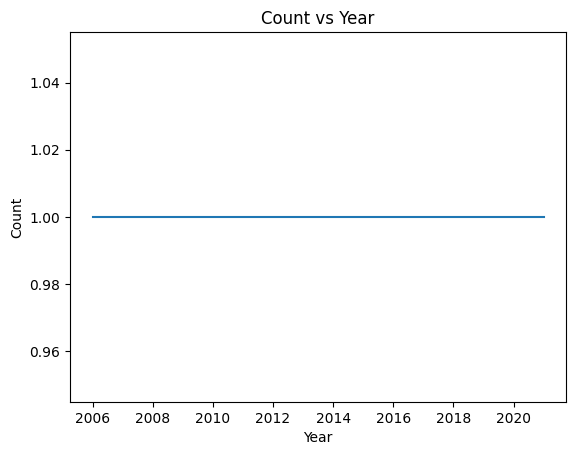

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
k = response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
data = dict(zip(k[::2], k[1::2]))


# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(data.items()), columns=['Date', 'Count'])

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the date
df['Year'] = df['Date'].dt.year

# Count the occurrences of each year
year_counts = df['Year'].value_counts().sort_index()

# Plot the counts vs year
year_counts.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count vs Year')
plt.show()


<Axes: >

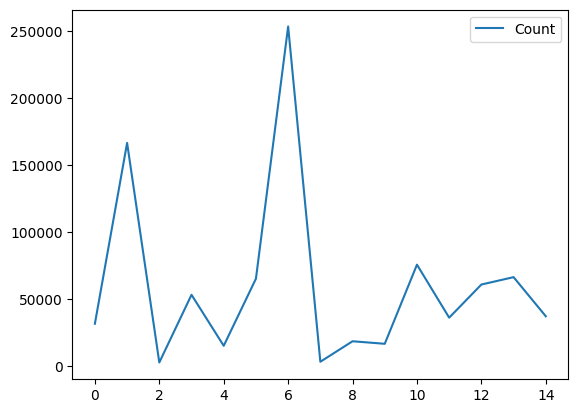

In [54]:
k = response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
data = dict(zip(k[::2], k[1::2]))

df = pd.DataFrame(list(data.items()), columns=['Date', 'Count'])
df.plot()

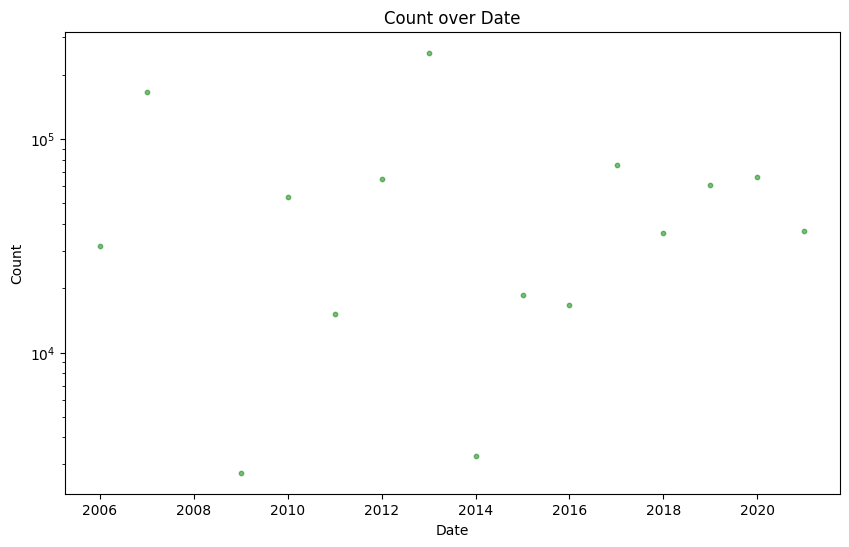

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame
df['Date'] = pd.to_datetime(df['Date'])

# deal with log scale
df = df.loc[df['Count'] != 0]

# df['Count'] = df['Count'].replace(0, np.nan)
# df['Count'] = df['Count'].fillna(0.1)

# Create histogram of record update timestamps
plt.figure(figsize=(10,6))
plt.scatter(df['Date'], df['Count'], color='green', alpha=0.5, s=10)
plt.yscale('log')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Date')
plt.show()

In [56]:
%%bash

curl -X 'GET' \
  'https://central.isample.xyz/isamples_central/thing/select?facet=true&facet.mincount=0&facet.field=source' \
  -H 'accept: application/json'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1014    0  1014    0     0   3107      0 --:--:-- --:--:-- --:--:--  3120


{
  "responseHeader":{
    "zkConnected":true,
    "status":0,
    "QTime":194,
    "params":{
      "q":"*:*",
      "facet.field":"source",
      "fl":"id",
      "start":"0",
      "facet.mincount":"0",
      "rows":"10",
      "facet":"true",
      "wt":"json"}},
  "response":{"numFound":6680932,"start":0,"numFoundExact":true,"docs":[
      {
        "id":"IGSN:001000053"},
      {
        "id":"IGSN:001000054"},
      {
        "id":"IGSN:001000055"},
      {
        "id":"IGSN:001000056"},
      {
        "id":"IGSN:001000057"},
      {
        "id":"IGSN:001000058"},
      {
        "id":"IGSN:001000059"},
      {
        "id":"IGSN:00100005R"},
      {
        "id":"IGSN:00100005S"},
      {
        "id":"IGSN:00100005T"}]
  },
  "facet_counts":{
    "facet_queries":{},
    "facet_fields":{
      "source":[
        "SESAR",4688386,
        "OPENCONTEXT",1064831,
        "GEOME",605554,
        "SMITHSONIAN",322161]},
    "facet_ranges":{},
    "facet_intervals":{},
    "facet_h

In [57]:
len(field_names)

75

In [58]:
# get OpenContext sourced records
# fq = cli._fq_from_kwargs(source=('OPENCONTEXT', 'SESAR'), collection_date_end=str(datetime.now().year))
fq = cli._fq_from_kwargs(collection_date_end=str(datetime.now().year))

params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)


In [59]:
# Get counts of values grouping by three dimensions: source, hasMaterialCategory, and hasContextCategory
dimensions = ["source", "hasMaterialCategory", "hasContextCategory"]
xd = cli.pivot(params, dimensions)
# print(xd.loc["geome", "organic material", "bacteria"].sum())
# Using the full URIs from the output
print(xd.loc["geome", 
            "https://w3id.org/isample/vocabulary/material/1.0/organicmaterial",
            "https://w3id.org/isample/biology/biosampledfeature/1.0/bacteria"].sum())

<xarray.DataArray ()> Size: 8B
np.int64(2)
Coordinates:
    source               <U11 44B 'geome'
    hasMaterialCategory  <U75 300B 'https://w3id.org/isample/vocabulary/mater...
    hasContextCategory   <U82 328B 'https://w3id.org/isample/biology/biosampl...


In [60]:
# Print unique values in each dimension to see what's available
print("Available sources:")
print(xd.coords['source'].values)
print("\nAvailable material categories:")
print(xd.coords['hasMaterialCategory'].values)
print("\nAvailable context categories:")
print(xd.coords['hasContextCategory'].values)

Available sources:
['sesar' 'opencontext' 'geome' 'smithsonian']

Available material categories:
['https://w3id.org/isample/vocabulary/material/1.0/earthmaterial'
 'https://w3id.org/isample/vocabulary/material/1.0/rock'
 'https://w3id.org/isample/vocabulary/material/1.0/mixedsoilsedimentrock'
 'https://w3id.org/isample/vocabulary/material/1.0/material'
 'https://w3id.org/isample/vocabulary/material/1.0/mineral'
 'https://w3id.org/isample/vocabulary/material/1.0/biogenicnonorganicmaterial'
 'https://w3id.org/isample/vocabulary/material/1.0/organicmaterial'
 'https://w3id.org/isample/vocabulary/material/1.0/sediment'
 'https://w3id.org/isample/vocabulary/material/1.0/soil'
 'https://w3id.org/isample/vocabulary/material/1.0/liquidwater'
 'https://w3id.org/isample/vocabulary/material/1.0/gas'
 'https://w3id.org/isample/vocabulary/material/1.0/anyanthropogenicmaterial'
 'https://w3id.org/isample/vocabulary/material/1.0/particulate'
 'https://w3id.org/isample/vocabulary/material/1.0/nonaqueo

In [61]:
# Sum by axis 2 (hasContextCategory) and print
df = xd.sum(axis=2).to_pandas()
# display transposed
display(df.T)


source,sesar,opencontext,geome,smithsonian
hasMaterialCategory,,,,
https://w3id.org/isample/vocabulary/material/1.0/earthmaterial,2233939,27574,0,0
https://w3id.org/isample/vocabulary/material/1.0/rock,913709,295730,0,0
https://w3id.org/isample/vocabulary/material/1.0/mixedsoilsedimentrock,838805,0,0,0
https://w3id.org/isample/vocabulary/material/1.0/material,509645,163373,0,0
https://w3id.org/isample/vocabulary/material/1.0/mineral,390795,0,0,0
https://w3id.org/isample/vocabulary/material/1.0/biogenicnonorganicmaterial,346242,745539,0,0
https://w3id.org/isample/vocabulary/material/1.0/organicmaterial,281834,56011,234422,287072
https://w3id.org/isample/vocabulary/material/1.0/sediment,93014,0,0,0
https://w3id.org/isample/vocabulary/material/1.0/soil,37153,0,0,0


In [62]:
print(xd.loc["sesar", "https://w3id.org/isample/vocabulary/material/1.0/rock"].sum())

<xarray.DataArray ()> Size: 8B
np.int64(913709)
Coordinates:
    source               <U11 44B 'sesar'
    hasMaterialCategory  <U75 300B 'https://w3id.org/isample/vocabulary/mater...


In [63]:
def shorten_material_category(uri):
    """Convert material category URI to short name"""
    if not uri or not isinstance(uri, str):
        return ''
    return uri.split('/')[-1]

def shorten_context_category(uri):
    """Convert context category URI to short name"""
    if not uri or not isinstance(uri, str):
        return ''
    return uri.split('/')[-1]

# Create new coordinates with shortened names
xd_short = xd.copy()
xd_short.coords['hasMaterialCategory'] = ('hasMaterialCategory', 
    [shorten_material_category(x) for x in xd.coords['hasMaterialCategory'].values])
xd_short.coords['hasContextCategory'] = ('hasContextCategory',
    [shorten_context_category(x) for x in xd.coords['hasContextCategory'].values])

# Now you can use shorter names
# print(xd_short.loc["geome", "organicmaterial", "bacteria"].sum())
print(f"Number of matches: {int(xd_short.loc['geome', 'organicmaterial', 'bacteria'])}")

Number of matches: 2


In [64]:
# Field names in solr
for name in cli.field_names():
    print(name)

_nest_parent_
_nest_path_
_root_
_text_
_version_
authorizedBy
compliesWith
curation_accessContraints
curation_description
curation_description_text
curation_label
curation_location
curation_responsibility
description
description_text
hasContextCategory
hasContextCategoryConfidence
hasMaterialCategory
hasMaterialCategoryConfidence
hasSpecimenCategory
hasSpecimenCategoryConfidence
id
indexUpdatedTime
informalClassification
isb_core_id
keywords
label
producedBy_description
producedBy_description_text
producedBy_hasFeatureOfInterest
producedBy_isb_core_id
producedBy_label
producedBy_responsibility
producedBy_resultTime
producedBy_resultTimeRange
producedBy_samplingSite_description
producedBy_samplingSite_description_text
producedBy_samplingSite_label
producedBy_samplingSite_location_bb
producedBy_samplingSite_location_bb__maxX
producedBy_samplingSite_location_bb__maxY
producedBy_samplingSite_location_bb__minX
producedBy_samplingSite_location_bb__minY
producedBy_samplingSite_location_bb__x

# Geoparquet

In [65]:
import duckdb
import time
import ibis



def print_timing(start_time, operation):
    elapsed = time.time() - start_time
    print(f"Time for {operation}: {elapsed:.2f} seconds")

# Connect to an in-memory DuckDB instance
start_time = time.time()
con = duckdb.connect()
print_timing(start_time, "database connection")

# Load the GeoParquet file and create view
start_time = time.time()
geo_parquet_file = '/Users/raymondyee/Data/iSample/2025_02_20_10_30_49/isamples_export_2025_02_20_10_30_49_geo.parquet'
con.sql(f"CREATE VIEW geosamples AS SELECT * FROM read_parquet('{geo_parquet_file}')")
print_timing(start_time, "creating view")

# Get column names dynamically
start_time = time.time()
columns = con.sql("SELECT column_name FROM information_schema.columns WHERE table_name = 'geosamples'").fetchall()
column_names = [col[0] for col in columns]
print_timing(start_time, "getting column names")

# Print available columns
print("\nAvailable columns:")
for col in column_names:
    print(f"- {col}")

# Get total row count
start_time = time.time()
row_count = con.sql("SELECT COUNT(*) FROM geosamples").fetchone()[0]
print(f"\nTotal number of rows: {row_count:,}")
print_timing(start_time, "counting rows")

# Query the first 5 rows with all columns
start_time = time.time()
result = con.sql("""
    SELECT *
    FROM geosamples 
    LIMIT 5
""").df()
print_timing(start_time, "querying sample rows")

print("\nFirst 5 rows:")
print(result)

Time for database connection: 0.01 seconds
Time for creating view: 0.00 seconds
Time for getting column names: 0.01 seconds

Available columns:
- sample_identifier
- label
- description
- source_collection
- has_sample_object_type
- has_material_category
- has_context_category
- informal_classification
- keywords
- produced_by
- curation
- registrant
- related_resource
- sampling_purpose
- sample_location_longitude
- sample_location_latitude
- geometry

Total number of rows: 6,494,541
Time for counting rows: 0.00 seconds
Time for querying sample rows: 0.03 seconds

First 5 rows:
    sample_identifier label                       description  \
0  ark:/21547/DSz2757   757  basisOfRecord: PreservedSpecimen   
1  ark:/21547/DSz2779   779  basisOfRecord: PreservedSpecimen   
2  ark:/21547/DSz2806   806  basisOfRecord: PreservedSpecimen   
3  ark:/21547/DSz2807   807  basisOfRecord: PreservedSpecimen   
4  ark:/21547/DSz2759   759  basisOfRecord: PreservedSpecimen   

  source_collection    

Data loading and sampling time: 1.52 seconds
Total execution time: 2.58 seconds


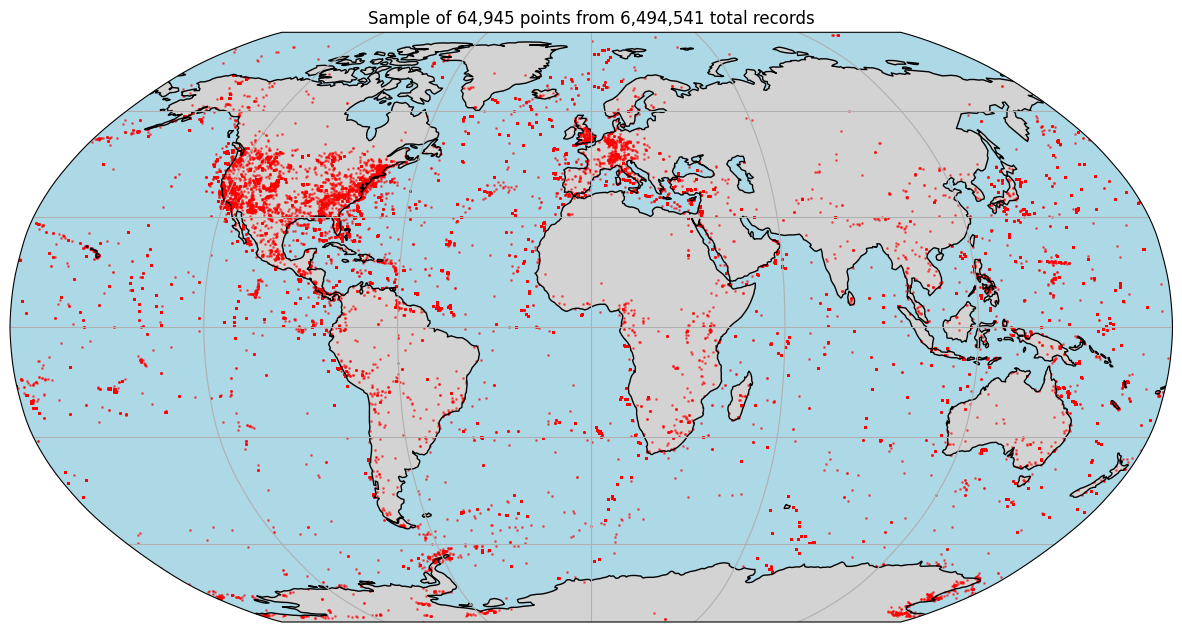

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time

# Start timing
start_time = time.time()

# Read only a sample of the data (e.g., 1% for better performance)
# geo_parquet_file = '/Users/raymondyee/Data/iSample/2025_02_20_10_30_49/isamples_export_2025_02_20_10_30_49_geo.parquet'
geo_parquet_file = '/Users/raymondyee/Data/iSample/2025_04_21_16_23_46/isamples_export_2025_04_21_16_23_46_geo.parquet'
gdf = gpd.read_parquet(geo_parquet_file, columns=['geometry'])  # Only read geometry column

# Create map visualization of geographical sample points
# Sampling only 1% of data for better performance with large datasets
sample_size = len(gdf) // 100  # 1% of data
gdf_sampled = gdf.sample(n=sample_size, random_state=42)

print(f"Data loading and sampling time: {time.time() - start_time:.2f} seconds")

# Create figure and axis with larger size and projection
fig, ax = plt.subplots(figsize=(15, 10), 
                       subplot_kw={'projection': ccrs.Robinson()})

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

# Plot with improved styling
gdf_sampled.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    alpha=0.5,
    markersize=1,
    color='red',
    legend=True
)

# Add title
plt.title(f'Sample of {sample_size:,} points from {len(gdf):,} total records')

print(f"Total execution time: {time.time() - start_time:.2f} seconds")

plt.show()

In [67]:
import duckdb
import os

# Change working directory to the location of the GeoParquet file
os.chdir('/Users/raymondyee/Data/iSample/2025_02_20_10_30_49')

# Initialize DuckDB connection
conn = duckdb.connect(':memory:')  # or specify a database file

# Install and load spatial extension
conn.execute("INSTALL spatial;")
conn.execute("LOAD spatial;")

# Create temp view from parquet file
conn.execute("""
    CREATE TEMP VIEW my_data AS 
    SELECT * FROM read_parquet('isamples_export_2025_02_20_10_30_49_geo.parquet')
""")

# Get count of rows
result = conn.execute("SELECT COUNT(*) FROM my_data").fetchall()

# Print result
print(f"Total rows: {result[0][0]}")

# Close connection
conn.close()

Total rows: 6494541


In [68]:
import duckdb

# Change working directory to the location of the GeoParquet file
os.chdir('/Users/raymondyee/Data/iSample/2025_02_20_10_30_49')

# Create connection
conn = duckdb.connect(':memory:')
conn.execute("INSTALL spatial; LOAD spatial;")

# DuckDB can query Parquet directly - no need to create views
query = conn.table('isamples_export_2025_02_20_10_30_49_geo.parquet')

# Queries stay lazy until you need results
print(f"Total rows: {query.count()}")

# You can chain operations naturally
filtered = query.filter("some_condition").limit(5)

# Only converts to DataFrame when you actually call .df()
# filtered_df = filtered.df()  # This would materialize the data



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

TypeError: count(): incompatible function arguments. The following argument types are supported:
    1. (self: duckdb.duckdb.DuckDBPyRelation, column: str, groups: str = '', window_spec: str = '', projected_columns: str = '') -> duckdb.duckdb.DuckDBPyRelation

Invoked with: ┌─────────────────────────┬──────────┬──────────────────────────────────────────────────┬───────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────┬────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────┬───────────────────────────────────────┬────────────────────┬───────────────────────────┬──────────────────────────┬───────────────────────────────┐
│    sample_identifier    │  label   │                   description                    │ source_collection │                                      has_sample_object_type                                      │                               has_material_category                                │                               has_context_category                                │  informal_classification   │                                                                                        keywords                                                                                        │                                                                                                                                                                                                                                                                           produced_by                                                                                                                                                                                                                                                                            │                                                                                                                                                                                                                                          curation                                                                                                                                                                                                                                          │       registrant       │           related_resource            │  sampling_purpose  │ sample_location_longitude │ sample_location_latitude │           geometry            │
│         varchar         │ varchar  │                     varchar                      │      varchar      │                                   struct(identifier varchar)[]                                   │                            struct(identifier varchar)[]                            │                           struct(identifier varchar)[]                            │         varchar[]          │                                                                               struct(keyword varchar)[]                                                                                │                                                                                                          struct(description varchar, has_feature_of_interest varchar, identifier varchar, "label" varchar, responsibility struct("name" varchar, "role" varchar)[], result_time varchar, sampling_site struct(description varchar, "label" varchar, place_name varchar[], sample_location struct(elevation double, latitude double, longitude double)))                                                                                                          │                                                                                                                                                               struct(access_constraints varchar[], curation_location varchar, description varchar, "label" varchar, responsibility struct("name" varchar, "role" varchar)[])                                                                                                                                                               │ struct("name" varchar) │       struct(target varchar)[]        │     varchar[]      │          double           │          double          │           geometry            │
├─────────────────────────┼──────────┼──────────────────────────────────────────────────┼───────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────┼────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼───────────────────────────────────────┼────────────────────┼───────────────────────────┼──────────────────────────┼───────────────────────────────┤
│ ark:/21547/DSz2757      │ 757      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2757, 'label': a22d568d303a95c622a9409871e562d7 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1894-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 38.578888, 'longitude': -122.57861}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.57861 │                38.578888 │ POINT (-122.57861 38.578888)  │
│ ark:/21547/DSz2779      │ 779      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2779, 'label': 096c166b0c23c8823678eb43e4c00802 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1893-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 37.385277, 'longitude': -122.373055}}}                                        │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │               -122.373055 │                37.385277 │ POINT (-122.373055 37.385277) │
│ ark:/21547/DSz2806      │ 806      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2806, 'label': 4824d73db4a747e634637f1a3c2978cb newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1893-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 37.36549, 'longitude': -122.11705}}}                                          │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.11705 │                 37.36549 │ POINT (-122.11705 37.36549)   │
│ ark:/21547/DSz2807      │ 807      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2807, 'label': 4824d73db4a747e634637f1a3c2978cb newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1893-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 37.36549, 'longitude': -122.11705}}}                                          │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.11705 │                 37.36549 │ POINT (-122.11705 37.36549)   │
│ ark:/21547/DSz2759      │ 759      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2759, 'label': a22d568d303a95c622a9409871e562d7 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1894-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 38.578888, 'longitude': -122.57861}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.57861 │                38.578888 │ POINT (-122.57861 38.578888)  │
│ ark:/21547/DSz2761      │ 761      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2761, 'label': a22d568d303a95c622a9409871e562d7 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1894-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 38.578888, 'longitude': -122.57861}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.57861 │                38.578888 │ POINT (-122.57861 38.578888)  │
│ ark:/21547/DSz2967      │ 967      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, torosa]          │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2967, 'label': 1b092798b61f72c79ff6df1f361b8705 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1894-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 38.669395, 'longitude': -122.63218}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.63218 │                38.669395 │ POINT (-122.63218 38.669395)  │
│ ark:/21547/DSz2763      │ 763      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, granulosa]       │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2763, 'label': a22d568d303a95c622a9409871e562d7 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1894-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 38.578888, 'longitude': -122.57861}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.57861 │                38.578888 │ POINT (-122.57861 38.578888)  │
│ ark:/21547/DSz2979      │ 979      │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, torosa]          │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz2979, 'label': ac6f9b6dd20fd04e411c2db0348524e3 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1894-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 34.147778, 'longitude': -118.14361}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -118.14361 │                34.147778 │ POINT (-118.14361 34.147778)  │
│ ark:/21547/DSz21792     │ 1792     │ basisOfRecord: PreservedSpecimen                 │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Taricha, torosa]          │ [{'keyword': California}, {'keyword': USA}]                                                                                                                                            │ {'description': expeditionCode: newts | projectId: 244, 'has_feature_of_interest': , 'identifier': ark:/21547/DSz21792, 'label': ed5754fe295e377d6da2add6748fb7c0 newts, 'responsibility': [{'name': Vance Vredenburg, 'role': collector }, {'name':  Vance Vredenburg, 'role': principalInvestigator}], 'result_time': 1896-01-01, 'sampling_site': {'description': NULL, 'label': California, 'place_name': [California, USA], 'sample_location': {'elevation': NULL, 'latitude': 37.87103, 'longitude': -122.27711}}}                                         │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       │ NULL                   │ NULL                                  │ NULL               │                -122.27711 │                 37.87103 │ POINT (-122.27711 37.87103)   │
│          ·              │  ·       │  ·                                               │   ·               │                                                ·                                                 │                                         ·                                          │                                         ·                                         │         ·                  │                      ·                                                                                                                                                                 │  ·                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               │  ·                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │  ·                     │  ·                                    │  ·                 │                        ·  │                       ·  │      ·                        │
│          ·              │  ·       │  ·                                               │   ·               │                                                ·                                                 │                                         ·                                          │                                         ·                                         │         ·                  │                      ·                                                                                                                                                                 │  ·                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               │  ·                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │  ·                     │  ·                                    │  ·                 │                        ·  │                       ·  │      ·                        │
│          ·              │  ·       │  ·                                               │   ·               │                                                ·                                                 │                                         ·                                          │                                         ·                                         │         ·                  │                      ·                                                                                                                                                                 │  ·                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               │  ·                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │  ·                     │  ·                                    │  ·                 │                        ·  │                       ·  │      ·                        │
│ ark:/21547/BNt2CmMQ0005 │ CmMQ0005 │ NULL                                             │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/organismpart}]  │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Ctenochaetus, marginatus] │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}, {'keyword': Ua Huka}] │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/ot2CmMQ0005}]  │ [genomic analysis] │                      NULL │                     NULL │ POINT EMPTY                   │
│ ark:/21547/ot2ANMQ0165  │ ANMQ0165 │ previousIdentifications: Acanthurus nigricans    │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Acanthurus, nigricans]    │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}]                       │ {'description': expeditionCode: IPfish_A68_HL | projectId: 1, 'has_feature_of_interest': , 'identifier': ark:/21547/ot2ANMQ0165, 'label': a8b1f9fa321073f72f9a7881747ab592 IPfish_A68_HL, 'responsibility': [{'name': D. R. Robertson, 'role': collector }, {'name':  H. A. Lessios, 'role': principalInvestigator}], 'result_time': 1995-05-01, 'sampling_site': {'description': NULL, 'label': Marquesas, 'place_name': [French Polynesia, Marquesas], 'sample_location': {'elevation': NULL, 'latitude': -9.0, 'longitude': -139.3}}}                         │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/BNt2ANMQ0165}] │ NULL               │                    -139.3 │                     -9.0 │ POINT (-139.3 -9)             │
│ ark:/21547/BNt2ANMQ0165 │ ANMQ0165 │ NULL                                             │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/organismpart}]  │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Acanthurus, nigricans]    │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}]                       │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/ot2ANMQ0165}]  │ [genomic analysis] │                      NULL │                     NULL │ POINT EMPTY                   │
│ ark:/21547/ot2CmMQ0004  │ CmMQ0004 │ previousIdentifications: Ctenochaetus marginatus │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Ctenochaetus, marginatus] │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}, {'keyword': Ua Huka}] │ {'description': expeditionCode: IPfish_A68_HL | projectId: 1, 'has_feature_of_interest': , 'identifier': ark:/21547/ot2CmMQ0004, 'label': c8e4608b0409567824c8badfbaef685f IPfish_A68_HL, 'responsibility': [{'name': D. R. Robertson, 'role': collector }, {'name':  H. A. Lessios, 'role': principalInvestigator}], 'result_time': 1995-05-01, 'sampling_site': {'description': NULL, 'label': ua-huka, 'place_name': [French Polynesia, Marquesas, Ua Huka, ua-huka], 'sample_location': {'elevation': NULL, 'latitude': -8.90864, 'longitude': -139.55984}}} │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/BNt2CmMQ0004}] │ NULL               │                -139.55984 │                 -8.90864 │ POINT (-139.55984 -8.90864)   │
│ ark:/21547/BNt2CmMQ0004 │ CmMQ0004 │ NULL                                             │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/organismpart}]  │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Ctenochaetus, marginatus] │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}, {'keyword': Ua Huka}] │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/ot2CmMQ0004}]  │ [genomic analysis] │                      NULL │                     NULL │ POINT EMPTY                   │
│ ark:/21547/ot2CmMQ0007  │ CmMQ0007 │ previousIdentifications: Ctenochaetus marginatus │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Ctenochaetus, marginatus] │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}, {'keyword': Ua Huka}] │ {'description': expeditionCode: IPfish_A68_HL | projectId: 1, 'has_feature_of_interest': , 'identifier': ark:/21547/ot2CmMQ0007, 'label': c8e4608b0409567824c8badfbaef685f IPfish_A68_HL, 'responsibility': [{'name': D. R. Robertson, 'role': collector }, {'name':  H. A. Lessios, 'role': principalInvestigator}], 'result_time': 1995-05-01, 'sampling_site': {'description': NULL, 'label': ua-huka, 'place_name': [French Polynesia, Marquesas, Ua Huka, ua-huka], 'sample_location': {'elevation': NULL, 'latitude': -8.90864, 'longitude': -139.55984}}} │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/BNt2CmMQ0007}] │ NULL               │                -139.55984 │                 -8.90864 │ POINT (-139.55984 -8.90864)   │
│ ark:/21547/BNt2CmMQ0007 │ CmMQ0007 │ NULL                                             │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/organismpart}]  │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Ctenochaetus, marginatus] │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}, {'keyword': Ua Huka}] │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/ot2CmMQ0007}]  │ [genomic analysis] │                      NULL │                     NULL │ POINT EMPTY                   │
│ ark:/21547/ot2ANMQ0136  │ ANMQ0136 │ previousIdentifications: Acanthurus nigricans    │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Acanthurus, nigricans]    │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}]                       │ {'description': expeditionCode: IPfish_A68_HL | projectId: 1, 'has_feature_of_interest': , 'identifier': ark:/21547/ot2ANMQ0136, 'label': a8b1f9fa321073f72f9a7881747ab592 IPfish_A68_HL, 'responsibility': [{'name': D. R. Robertson, 'role': collector }, {'name':  H. A. Lessios, 'role': principalInvestigator}], 'result_time': 1995-05-01, 'sampling_site': {'description': NULL, 'label': Marquesas, 'place_name': [French Polynesia, Marquesas], 'sample_location': {'elevation': NULL, 'latitude': -9.0, 'longitude': -139.3}}}                         │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/BNt2ANMQ0136}] │ NULL               │                    -139.3 │                     -9.0 │ POINT (-139.3 -9)             │
│ ark:/21547/BNt2ANMQ0136 │ ANMQ0136 │ NULL                                             │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/organismpart}]  │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Acanthurus, nigricans]    │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}]                       │ NULL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/ot2ANMQ0136}]  │ [genomic analysis] │                      NULL │                     NULL │ POINT EMPTY                   │
│ ark:/21547/ot2ANMQ0137  │ ANMQ0137 │ previousIdentifications: Acanthurus nigricans    │ GEOME             │ [{'identifier': https://w3id.org/isample/vocabulary/materialsampleobjecttype/1.0/wholeorganism}] │ [{'identifier': https://w3id.org/isample/vocabulary/material/1.0/organicmaterial}] │ [{'identifier': https://w3id.org/isample/biology/biosampledfeature/1.0/Animalia}] │ [Acanthurus, nigricans]    │ [{'keyword': Acanthuridae}, {'keyword': Actinopterygii}, {'keyword': Chordata}, {'keyword': French Polynesia}, {'keyword': Marquesas}, {'keyword': Perciformes}]                       │ {'description': expeditionCode: IPfish_A68_HL | projectId: 1, 'has_feature_of_interest': , 'identifier': ark:/21547/ot2ANMQ0137, 'label': a8b1f9fa321073f72f9a7881747ab592 IPfish_A68_HL, 'responsibility': [{'name': D. R. Robertson, 'role': collector }, {'name':  H. A. Lessios, 'role': principalInvestigator}], 'result_time': 1995-05-01, 'sampling_site': {'description': NULL, 'label': Marquesas, 'place_name': [French Polynesia, Marquesas], 'sample_location': {'elevation': NULL, 'latitude': -9.0, 'longitude': -139.3}}}                         │ {'access_constraints': [], 'curation_location': , 'description': preservative: DMSO Buffer, 'label': , 'responsibility': [{'name': c, 'role': curator}, {'name': u, 'role': curator}, {'name': r, 'role': curator}, {'name': a, 'role': curator}, {'name': t, 'role': curator}, {'name': o, 'role': curator}, {'name': r, 'role': curator}, {'name': , 'role': }, {'name': S, 'role': curator}, {'name': T, 'role': curator}, {'name': R, 'role': curator}, {'name': I, 'role': curator}]} │ NULL                   │ [{'target': ark:/21547/BNt2ANMQ0137}] │ NULL               │                    -139.3 │                     -9.0 │ POINT (-139.3 -9)             │
├─────────────────────────┴──────────┴──────────────────────────────────────────────────┴───────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────────────────────┴────────────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴────────────────────────┴───────────────────────────────────────┴────────────────────┴───────────────────────────┴──────────────────────────┴───────────────────────────────┤
│ ? rows (>9999 rows, 20 shown)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 17 columns │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘


In [ ]:
import os
import duckdb
from lonboard import viz

# Change working directory to the location of the GeoParquet file
os.chdir('/Users/raymondyee/Data/iSample/2025_02_20_10_30_49')

# Initialize DuckDB connection
conn = duckdb.connect(':memory:')

# Install and load spatial extension
conn.execute("INSTALL spatial;")
conn.execute("LOAD spatial;")

# First, let's check the geometry type and a sample
result = conn.execute("""
    SELECT 
        ST_GeometryType(geometry) as geom_type,
        ST_AsText(geometry) as wkt,
        sample_location_longitude,
        sample_location_latitude
    FROM read_parquet('isamples_export_2025_02_20_10_30_49_geo.parquet') 
    WHERE geometry IS NOT NULL 
    LIMIT 1
""").fetchall()
print(result)

# Create temp view using longitude/latitude to create geometry
conn.execute("""
    CREATE TEMP VIEW my_data AS 
    SELECT 
        ST_AsWKB(ST_Point(sample_location_longitude, sample_location_latitude)) as geometry,
        sample_identifier,
        label,
        description,
        source_collection,
        has_sample_object_type,
        has_material_category,
        has_context_category,
        informal_classification,
        keywords,
        produced_by,
        curation,
        registrant,
        related_resource,
        sampling_purpose,
        sample_location_longitude,
        sample_location_latitude
    FROM read_parquet('isamples_export_2025_02_20_10_30_49_geo.parquet')
    WHERE sample_location_longitude IS NOT NULL 
    AND sample_location_latitude IS NOT NULL
""")

# Check coordinate bounds
bounds = conn.execute("""
    SELECT 
        MIN(sample_location_longitude) as min_lon,
        MAX(sample_location_longitude) as max_lon,
        MIN(sample_location_latitude) as min_lat,
        MAX(sample_location_latitude) as max_lat,
        COUNT(*) as point_count
    FROM my_data
""").fetchall()
print("\nCoordinate bounds and point count:")
print(bounds)

# Query and visualize with map configuration
result = conn.sql("SELECT * FROM my_data")
viz(
    result,
    map_kwargs={
        "zoom": 1,  # Global view
        "center": {"lat": 0, "lon": 0}  # Center at equator
    }
)

[('POINT', 'POINT (-122.57861 38.578888)', -122.57861, 38.578888)]

Coordinate bounds and point count:
[(-180.0, 180.0, -89.983, 89.981, 5795511)]


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/Users/raymondyee/.pyenv/versions/3.12.9/envs/isamples-python-3.12.9/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:33: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


TypeError: 
Unexpected keyword argument: 'zoom'.
Check the spelling of your parameters. If you're trying to use layer properties added by
a layer extension, ensure you've passed the extension object into the `extensions`
parameter of the layer.
